# Task description

Description

This task is about forecasting how many bikes are rented from the TFL (Transport for London) Cycle Hire scheme.

Specifically, you should attempt to answer the question “Can national electrical power generation help estimate how many bikes are hired?”

The idea is that these two datasets may be correlated with data we don’t have information on (e.g. the weather).

Data Sources (attached):

    tfl-daily-cycle-hires.xlsx : the daily number of hired bikes. Downloaded from https://data.london.gov.uk/dataset/number-bicycle-hires
    electrical_power_data.csv. Downloaded from : https://www.ref.org.uk/fuel/index.php?valdate=2009&tab=dp&share=N (Substituted “2009” in the URL to get data for later years)

You may also use other data sources of your choice (e.g. the attached Bank Holidays ukbankholidays.csv).  

Deliverables

Note : A clear methodology supported by reasonable justifications is more important than an extremely accurate model.

You should produce a Jupyter Notebook with your solution, and submit a .zip folder with the file in .ipynb and .html formats.

Your solution should include:

    Some preliminary data exploration.
    A model which predicts TFL Cycle Hire numbers using ONLY the TFL dataset.
    A model which predicts TFL Cycle Hire numbers using the TFL and electrical power generation dataset.

You can use any model(s) of your choice. However, you should

    Give reasons for your choices.
    Outline how/why you selected the features which you used as inputs.
    Evaluate your model(s) through multiple metrics.

Feel free to ask any question you may have, but you are encouraged to use your own judgement if anything isn’t explicitly stated in the task description.

We generally expect candidates to spend around 3 hours on the task, depending on your availability.

# Plan

Based on description it is time-series data, we should follow SOTA approaches of time series forecasting

    - load data into pandas dataframes
    - check if we have seasonalities
    - check if we have outliers 
    - remove seasonalities and outliers
    - predict future for standartized time-series (it can be done with help of a framework)
    
The main idea of this research is to answer the question if 'electrical power generation' data can improve model quality.
To answer the question we have to:
    
    - chose a metric to compare quality
    - develop and optimize model(s) without 'electrical power generation' data
    - develop a model using 'electrical power generation' data
    - compare metric and answer the question

**It is not clear from description if we can use 'future' electrical data.**
I guess it doesn't make sense to use tomorrow 'electrical power generation' data to predict tomorrow bike hires.
It may make sense only in case if electrical data can be collected faster then bike hires. Or we just want to find corellation like mentined here (The idea is that these two datasets may be correlated with data we don’t have information on e.g. the weather).
Anyway we will analyze both cases.

# Install requerements

In [1]:
# pandas openpyxl matplotlib plotly seaborn fbprophet 

# Import libs

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import plotly.express as px
import seaborn as sns
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import r2_score
from tqdm import tqdm

init_notebook_mode(connected = True)


# Configure the code

In [3]:
# fix config for you requirements and envirinment
config = {
    # the path to the input files
    "data_path": "./", 
    # based on EDA it is hard to say what is the reason of outliers. 
    # It depends of data quality. 
    # If the reason of outliers is incorrect measurements then it should be removed
    "remove_outliers": False ,
    # replace outlier with median of 'outliers_smooth' measurements around it
    "outliers_smooth": 7,
    # it depends on business purpose.
    # If we find that 'electrical power generation' data makes sense for 1 day prediction, then it will make sense for longet period
    "prediction_horizon":1,
    
}

# do not change it
config["data_path"] = Path(config["data_path"])

# Load the data

In [4]:
hires_raw = pd.read_excel(config['data_path'] / "tfl-daily-cycle-hires.xlsx", sheet_name="Data")
electrical_data = pd.read_csv(config['data_path'] / "electrical_power_data.csv")
holidays = pd.read_csv(config['data_path'] / "ukbankholidays.csv")

# Split hires data 

tfl-daily-cycle-hires.xlsx contains different information in a single table, it makes sense to extract several tables

In [5]:
hires_raw.head(1)

,Day,Number of Bicycle Hires,Unnamed: 2,Month,Number of Bicycle Hires.1,Unnamed: 5,Year,Number of Bicycle Hires.2,Unnamed: 8,Month.1,Average Hire Time (mins)
0,2010-07-30,6897,NaN,2010-07-01,12461.0,NaN,2010,2180813,NaN,2010-07-01,17.232566


In [6]:
hires_day = hires_raw.loc[:, ['Day', 'Number of Bicycle Hires', 'Year', 'Number of Bicycle Hires.2']]
hires_day.iloc[:13, 2:]= np.NaN
hires_day.columns = ['day', 'hires', 'month_diff', 'year_diff']
hires_day['y'] = hires_day['hires']
hires_day.head(15)

,day,hires,month_diff,year_diff,y
0,2010-07-30,6897,NaN,NaN,6897
1,2010-07-31,5564,NaN,NaN,5564
2,2010-08-01,4303,NaN,NaN,4303
3,2010-08-02,6642,NaN,NaN,6642
4,2010-08-03,7966,NaN,NaN,7966
5,2010-08-04,7893,NaN,NaN,7893
6,2010-08-05,8724,NaN,NaN,8724
7,2010-08-06,9797,NaN,NaN,9797
8,2010-08-07,6631,NaN,NaN,6631
9,2010-08-08,7864,NaN,NaN,7864


TODO. Extract hires_month

In [7]:
hires_year = hires_raw.loc[:9, ['Year', 'Number of Bicycle Hires.2']]
hires_year.columns = ['year', 'hires']
hires_year.head()

,year,hires
0,2010,2180813
1,2011,7142449
2,2012,9519283
3,2013,8045459
4,2014,10023897


# Prepare dataset

In [8]:
hires_day['ds']=pd.to_datetime(hires_day['day'])
hires_day["timestamp"] = hires_day['ds'].view('int64') // 10**9

electrical_data['ds'] = pd.to_datetime(electrical_data['SD'])
electrical_data['timestamp'] = electrical_data['ds'].view('int64') // 10**9


In [9]:
# don't we have date gaps?
assert np.all(hires_day['timestamp'].diff().values[1:] == 86400)
assert np.all(electrical_data['timestamp'].diff().values[1:] == 86400)

### Create a single dataset

In [10]:
del hires_day['timestamp']
dataset = pd.merge(electrical_data, hires_day, on="ds")

### replace strings to ints

In [11]:
def format_comma_int(value: str):
    try:
        return int(value.replace(',', ''))
    except:
        return None
assert format_comma_int("431,920") == 431920
assert format_comma_int("-4,582") == -4582
assert format_comma_int("431") == 431
assert format_comma_int("") is None
str2int_columns = ['Gas', 'Coal', 'Nuclear', 'Hydro', 'Net Pumped', 'Wind', 'OCGT',
       'Oil', 'Biomass', 'French Int', 'Dutch Int', 'NI Int', 'Eire Int',
       'Nemo Int', 'Net Supply', 
       ]
for c in str2int_columns:
    dataset[c] = dataset[c].apply(lambda x: format_comma_int(x))

In [12]:
holidays['ds'] = pd.to_datetime(holidays['UK BANK HOLIDAYS'])
holidays['holiday'] = 'UK BANK HOLIDAY'
holidays=holidays[['ds', 'holiday']]

In [13]:
dataset['dayofweek'] = dataset['ds'].dt.dayofweek
dataset['month'] = dataset['ds'].dt.month
dataset['year'] = dataset['ds'].dt.year

# EDA

In [14]:
dataset.head()

,SD,Gas,Coal,Nuclear,Hydro,Net Pumped,Wind,OCGT,Oil,Biomass,...,ds,timestamp,day,hires,month_diff,year_diff,y,dayofweek,month,year
0,2010-07-30,431920,184603,122467,4417,-4582,4841,15,0,0,...,2010-07-30,1280448000,2010-07-30,6897,NaN,NaN,6897,4,7,2010
1,2010-07-31,406077,111091,121983,4604,726,7013,0,0,0,...,2010-07-31,1280534400,2010-07-31,5564,NaN,NaN,5564,5,7,2010
2,2010-08-01,393442,109041,126746,4839,-6091,4264,0,0,0,...,2010-08-01,1280620800,2010-08-01,4303,NaN,NaN,4303,6,8,2010
3,2010-08-02,429981,190693,122512,3638,-2698,866,0,0,0,...,2010-08-02,1280707200,2010-08-02,6642,NaN,NaN,6642,0,8,2010
4,2010-08-03,433955,182201,125603,3594,-4137,5358,4,0,0,...,2010-08-03,1280793600,2010-08-03,7966,NaN,NaN,7966,1,8,2010


In [15]:
dataset.isna().sum()

SD               0
Gas              0
Coal             0
Nuclear          0
Hydro            0
Net Pumped       0
Wind             0
OCGT             0
Oil              0
Biomass          0
French Int       0
Dutch Int        0
NI Int           0
Eire Int         0
Nemo Int         0
Net Supply       0
ds               0
timestamp        0
day              0
hires            0
month_diff    3752
year_diff     3752
y                0
dayofweek        0
month            0
year             0
dtype: int64

In [16]:
(dataset==0).sum()

SD               0
Gas              0
Coal           288
Nuclear          0
Hydro            0
Net Pumped       1
Wind             0
OCGT          2434
Oil           3807
Biomass        569
French Int       0
Dutch Int      279
NI Int         350
Eire Int      1090
Nemo Int      3114
Net Supply       0
ds               0
timestamp        0
day              0
hires            0
month_diff       0
year_diff        0
y                0
dayofweek      552
month            0
year             0
dtype: int64

There are no gaps, we have data for each month (checked earlier)
There are no nans
But there are zeros for many measurements. Must be we just don't have these measurements

### plot hires by week
daily plot it is very nosy

In [17]:
def plotly_df(df, columns, title = ''):
    data = []

    for column in columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [18]:
plotly_df(dataset.set_index("ds").resample('W').apply(sum), columns=['hires'],  title = 'Bike Hires week')

We can see 
- yearly seasonality;
- growing trend at the begining. Must be it is the start of the business
- changes in the covid time

It makes sense to use algorithms for time series forecasting.

We don't know if there is a weekly seasonality here, lets check

In [19]:
dataset[['dayofweek', 'hires']].groupby("dayofweek")['hires'].mean()/dataset['hires'].mean()

dayofweek
0    1.001297
1    1.075545
2    1.077154
3    1.074504
4    1.035499
5    0.897300
6    0.839115
Name: hires, dtype: float64

looks like we have weekly seasonality

### lets check if different seasonality depends of each other

In [20]:
def plot_heatmap(columns, df = dataset):
    data = df[columns+['hires']]
    data=data.groupby(columns).mean().unstack()
    data.columns = data.columns.droplevel(0)
    data=data.fillna(0)
    f, ax = plt.subplots(figsize=(12,6))
    sns.heatmap(data, ax = ax, cmap=plt.cm.gray_r, vmax=data.values.max(), cbar_kws={'boundaries':np.arange(0,data.values.max(),100)})
    

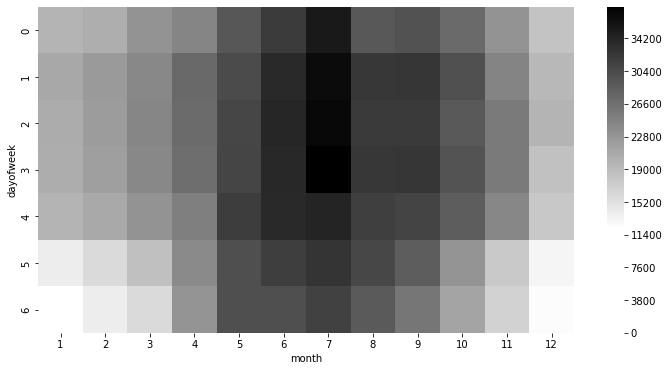

In [21]:
plot_heatmap(['dayofweek', 'month'])

dayofweek doesn't depend of month. bikes mostly hired on working days


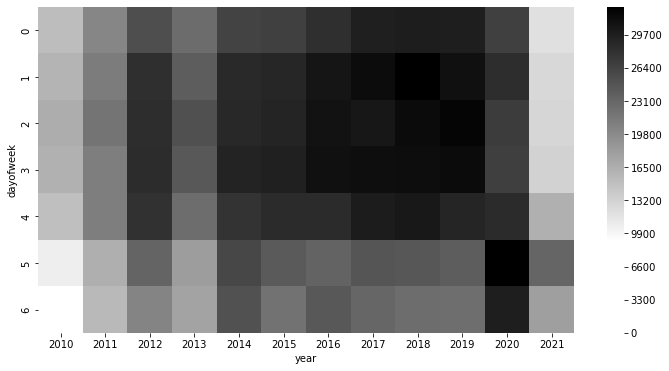

In [22]:
plot_heatmap(['dayofweek', 'year'])

here we see difference of activity in the covid year. People hire more on weekend


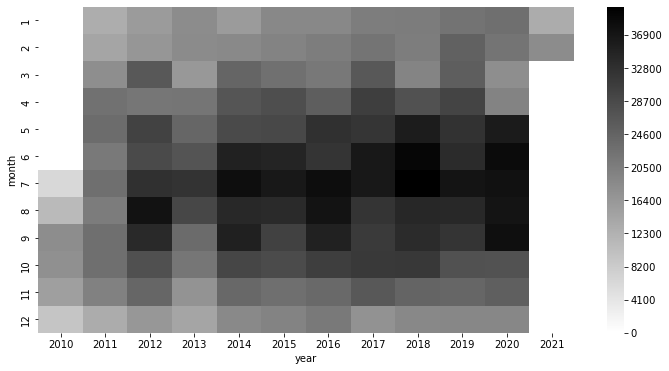

In [23]:
plot_heatmap(['month', 'year'])

don't see any special dependencies

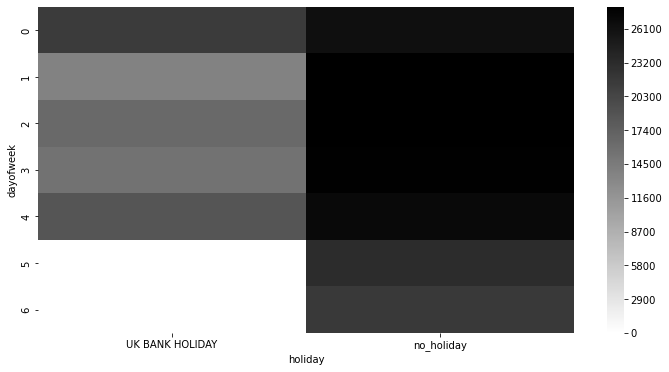

In [24]:
plot_heatmap(['dayofweek', 'holiday'], 
             pd.merge(dataset, holidays, on='ds', how='left').fillna({'holiday':"no_holiday"}))

holidays reduce hires every working day. it means that I have to use them for modeling.

### Next thing is to check outliers
Above we used week aggregations, but if we will try to predict daily data, it is necessary to check if there are  outliers.

In [25]:
dataset['outliers_effect'] =(dataset.hires-dataset.hires.rolling(config['outliers_smooth']).median()).fillna(0)


plotly_df(dataset.set_index("ds"), columns=['outliers_effect'],  title = 'outliers effect')
# outliers_effect is a difference of median value around N measuremnent and the particular measuremnent

In [26]:
px_tips = px.data.tips()
px.histogram(dataset, x="outliers_effect").show()

In [27]:
argmin = np.argmin(dataset['outliers_effect'])
argmax = np.argmax(dataset['outliers_effect'])

max(dataset['outliers_effect']), min(dataset['outliers_effect']), argmin, argmax

(36181.0, -27477.0, 786, 3606)

In [28]:
plotly_df(dataset.iloc[argmin-5:argmin+5].set_index("ds"), columns=['hires'],  title = 'min outlier')

Looks abnormal

In [29]:
plotly_df(dataset.iloc[argmax-5:argmax+5].set_index("ds"), columns=['hires'],  title = 'max outlier')

Looks normal

In [30]:
plot_columns = ['hires']+str2int_columns 
norm_energy_columns = dataset[plot_columns]/dataset[plot_columns].max(axis=0)
norm_energy_columns["ds"]=dataset["ds"]
plotly_df(norm_energy_columns.set_index("ds").resample('W').apply(sum), columns=plot_columns,  title = "All columns")

There are several features which are mostly zeros. 
Hard to say if there is a correlation between them and hires because we can see only seasonality.
Best way is to use them while modeling and look at the metric.

### how other features looks when hires is outlier?

In [31]:
plotly_df(norm_energy_columns.iloc[argmin-5:argmin+5].set_index("ds"), columns=plot_columns,  title = "max outlier")

In [32]:
plotly_df(norm_energy_columns.iloc[argmax-5:argmax+5], columns=plot_columns,  title = "min outlier")

Don't see any unusial values when hires is outlier.

### replace outliers with median value around it, if remove_outliers is true in config

In [33]:
min_outlier, max_outlier = dataset.outliers_effect.quantile([0.005, 0.995]).values

In [34]:
dataset['y_no_outliers']=dataset['hires']
outliers_condition = (dataset.outliers_effect<min_outlier) | (dataset.outliers_effect>max_outlier)
dataset.loc[outliers_condition, 'y_no_outliers'] = dataset.loc[outliers_condition, 'hires'].values-dataset.loc[outliers_condition, 'outliers_effect'].values

In [35]:
plotly_df(dataset.iloc[argmax-5:argmax+5].set_index("ds"), columns=['y', 'y_no_outliers', 'outliers_effect'],  title = 'Bike Hires outliers')

In [36]:
if config['remove_outliers']:
    dataset['y']=dataset['y_no_outliers']

# A model which predicts TFL Cycle Hire numbers using ONLY the TFL dataset.

### The task to forecast time series. There are several approaches to do it:

    - manually create features and predict values
    - use neural networks 
    - use a frameworks like Prophet
Here we want to try something easy to develop, so we start with Prophet

## Autoregression Model (Prophet)

### lets check if it can find trend and seasonalities

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -55.2623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7640.73    0.00406204       144.935           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        7646.3   9.64591e-05       98.0578      0.4466      0.4466      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7648.49    0.00126237       59.5405       2.494           1      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7649.31    0.00123754       191.719      0.0976           1      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7649.96    0.00194037       92.8548      0.9109      0.9109      631   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



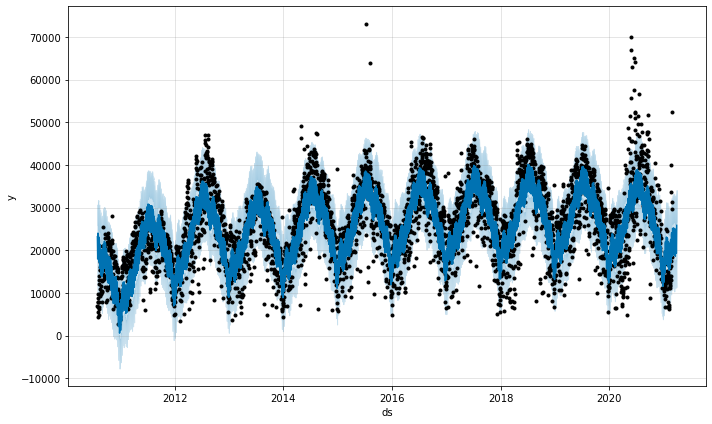

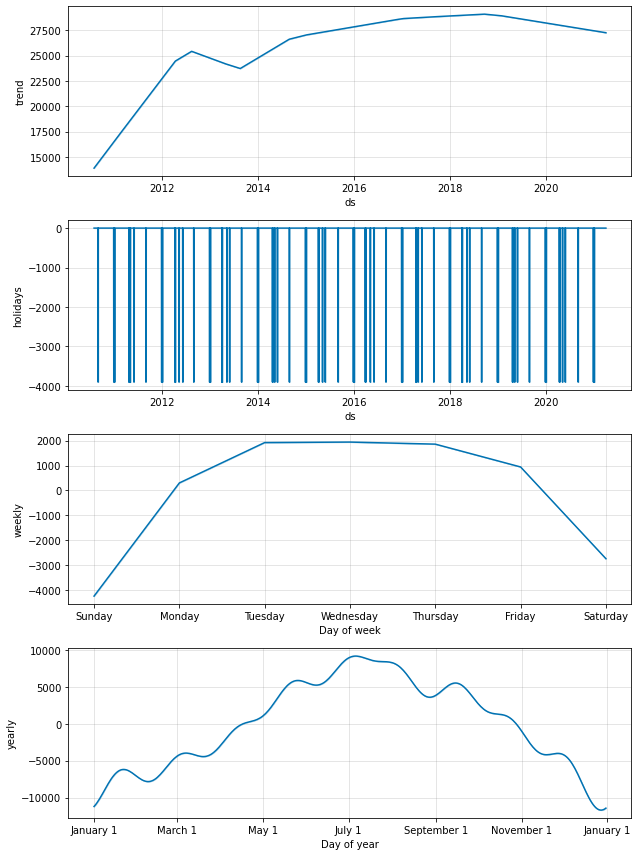

In [37]:
model = Prophet(holidays=holidays)
model.fit(dataset)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
model.plot(forecast);
model.plot_components(forecast);

It found the same pattern as we had found manually:

- yearly seasonality
- weekly seasonality, with lower values on weekends
- lower hires on holidays
- raising trend at the begining. May be we should increase regularization for trend.

During EDA we found that weekly seasonality changed in 2020, lets try to use it.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -55.2623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7755.84     0.0101999       250.196           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7766.86    0.00840366       87.0044           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       7768.63   8.42515e-05       84.3644   8.731e-07       0.001      353  LS failed, Hessian reset 
     299       7768.87    0.00118111       91.0958           1           1      402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7771.29   0.000516574       71.1845      0.5105      0.5105      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     433        7771.5   0.000128675    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

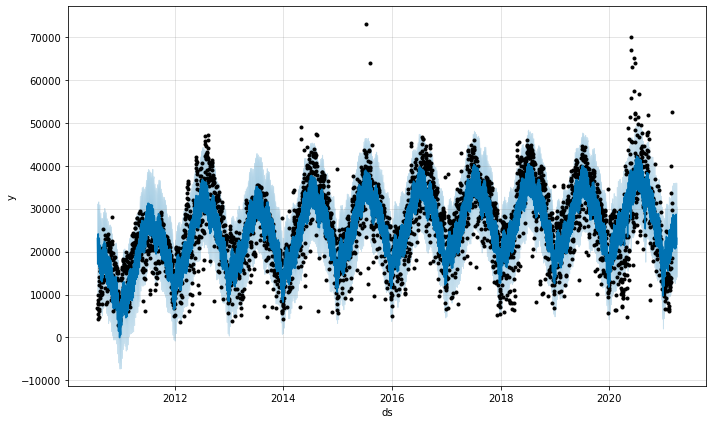

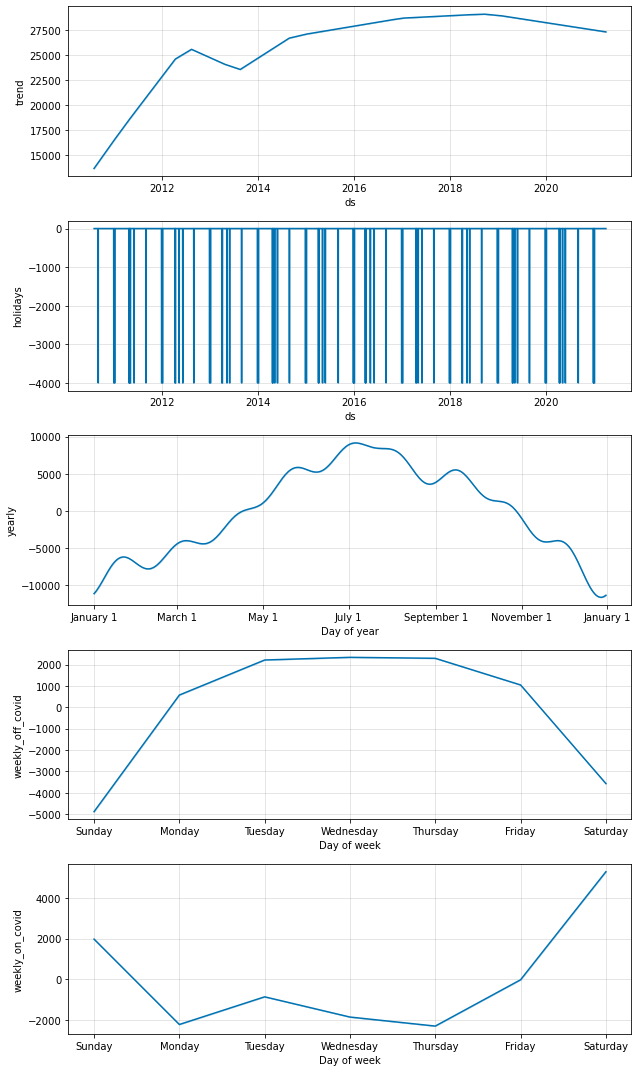

In [38]:
def is_covid(ds):
    # May be it is already changed back? 
    return ds.year >= 2020 and ds.month > 1

dataset['on_covid'] = dataset['ds'].apply(is_covid)
dataset['off_covid'] = ~dataset['ds'].apply(is_covid)

m = Prophet(holidays=holidays, weekly_seasonality=False, yearly_seasonality=True)

m.add_seasonality(name='weekly_on_covid', period=7, fourier_order=3, condition_name='on_covid')
m.add_seasonality(name='weekly_off_covid', period=7, fourier_order=3, condition_name='off_covid')

future['on_covid'] = future['ds'].apply(is_covid)
future['off_covid'] = ~future['ds'].apply(is_covid)

forecast = m.fit(dataset).predict(future)
m.plot(forecast);
fig = m.plot_components(forecast)



It found the same pattern. With covid we have different weekly seasonality

Prophet is a good framework to forecast time-series data. It makes sense to try other approaches (e.g DNN) later but it is good enough to solve current task. We can optimize it and then simly add 'electrical power generation' data. To optimize it we should choose a metric to optimize.

# Choose a metric


1. MAE vs MSE vs MAPE

We analized outliers. If they are really outliers we have to smooth them. So there is no problem to use MSE.
If we really want to predict these unexpected values then we should choose MSE otherwise MAE is better.

We also have seasonality and absolute values changes significantly. MAE and especially MSE will have higher error for summer period. It makes sense to use relative metric MAPE.

So we choose MAPE for quality estimation.

2. Bias

If we predict more then actual value, business will (buy/charge/setup depending of period) more bikes then necessary.
If we predict less, business will earn less money and may loose clients. 
I guess it is more risky to predict less, so it is important to check bias

3. R^2

Our purpose is to analyze if 'electrical power generation' data is valuable. 
If it will reduce dispersion than it is valuable.



**Find minimum MAPE without 'electrical power generation' data, than add 'electrical power generation' data.
If MAPE and R^2 are lower and Bias at least the same, then it is valuable.**

### cross validation
Now we want to tune hyperparameters. The main idea of this research is to answer the question **"Can national electrical power generation help estimate how many bikes are hired?"**
We don't really want to predict immediatly and last year of data is noisy because of covid, it is better to validate model over several periods.

In [68]:
model = Prophet(holidays=holidays)
model.fit(dataset)
initial_3_years = str(365*3) + ' days'
df_cv = cross_validation(model, initial=initial_3_years, period='120 days', horizon = str(config["prediction_horizon"]) + ' days')
df_p = performance_metrics(df_cv, rolling_window=1) # mean of all horizonts
# fig = plot_cross_validation_metric(df_cv, metric='mape')

In [40]:
df = px.data.tips()
fig = px.box(df_cv, y=["y", "yhat"])
fig.show()

In [41]:
df_cv["leaves"]=df_cv['yhat']-df_cv['y']
px_tips = px.data.tips()
px.histogram(df_cv, x=['leaves']).show()

In [42]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,2.628481e+07,5126.870926,3807.641331,0.176678,0.08826,0.791667


### Lets search for optimal parameters

In [43]:

def train(params, regressors=[], df=dataset, period = 120):
    m = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'], 
                seasonality_prior_scale=params['seasonality_prior_scale'], 
                holidays_prior_scale=params['holidays_prior_scale'], 
                holidays=holidays, 
                daily_seasonality=False,
                weekly_seasonality=not params["use_covid_for_weeks"], 
                yearly_seasonality=True,
                seasonality_mode=params['seasonality_mode']
               )
    if params["use_covid_for_weeks"]:
        m.add_seasonality(name='weekly_on_covid', period=7, fourier_order=3, condition_name='on_covid')
        m.add_seasonality(name='weekly_off_covid', period=7, fourier_order=3, condition_name='off_covid')
    for c in regressors:
        m.add_regressor(c, prior_scale=0.5)
    m.fit(df) 
    initial_3_years = str(365*3) + ' days'
    df_cv = cross_validation(m, initial=initial_3_years, 
                             period= str(period) + ' days',
                             horizon = str(config["prediction_horizon"]) + ' days', 
#                              parallel='processes'
                            )
    
    df_p = performance_metrics(df_cv, rolling_window=1) # mean of all horizonts
    return df_cv, df_p
    

In [44]:
param_grid = {  
#     'changepoint_prior_scale': [0.25, 0.05, 0.1], # [default/2,default,default*2]
#     'seasonality_prior_scale': [5.0, 10.0, 20.0],  # [default/2,default,default*2]
#     'holidays_prior_scale': [5.0, 10.0, 20.0],  # [default/2,default,default*2]
    'changepoint_prior_scale': [0.05],
    'seasonality_prior_scale': [10.0],  
    'holidays_prior_scale': [10.0], 
    'use_covid_for_weeks': [True, False],
    'seasonality_mode':['additive', 'multiplicative']
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

In [67]:
mapes = [] 
for params in tqdm(all_params):
    df_cv, df_p = train(params)
    mapes.append(df_p['mape'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

In [46]:
best = tuning_results.iloc[tuning_results.mape.argmin()].to_dict()
best

{'changepoint_prior_scale': 0.05,
 'seasonality_prior_scale': 10.0,
 'holidays_prior_scale': 10.0,
 'use_covid_for_weeks': False,
 'seasonality_mode': 'multiplicative',
 'mape': 0.16919253282263694}

weird best params:

- we can see that use_covid_for_weeks makes sense based on analisys and predictions
- seasonality_mode doesn't look multiplicative

Make sense to check it later for more models in CV

In [66]:
df_cv, df_p = train(best)

In [48]:
df = px.data.tips()
fig = px.box(df_cv, y=["y", "yhat"])
fig.show()

In [49]:
df_cv["leaves"]=df_cv['yhat']-df_cv['y']
px_tips = px.data.tips()
px.histogram(df_cv, x=['leaves']).show()

In [50]:
def plot_pred_vs_gt(df_cv, df_p):
    print('r2', r2_score(df_cv['y'], df_cv['yhat']))
    print('mape', df_p.mape.values[0])
    points = go.Scatter(
                x = df_cv['y'],
                y =  df_cv['yhat'],
                mode = 'markers',
                name = "points"
            )
    p1 = max(max(df_cv['yhat']), max(df_cv['y']))
    p2 = min(min(df_cv['yhat']), min(df_cv['y']))
    line = go.Scatter(
                x = [p1, p2],
                y =  [p1, p2],
                mode = 'lines',
                name = "line"
            )
    fig = dict(data = [points, line], layout = dict(title = "pred_vs_gt"))
    iplot(fig, show_link=False)

plot_pred_vs_gt(df_cv, df_p)
# r2 0.6624278003105619
# mape 0.17667807724596077

r2 0.6741766100137576
mape 0.16919253282263694


# Add regressors

Lets use best params without regressors. If we will have better metrics with this params, it will be enought.

### 1. Lets look at the future energy metrics. If future data improve quality, then it makes sense to continue

In [65]:
additional_features = ['Gas', 'Coal', 'Nuclear', 'Hydro', 'Net Pumped', 'Wind', 'OCGT',
       'Oil', 'Biomass', 'French Int', 'Dutch Int', 'NI Int', 'Eire Int',
       'Nemo Int', 'Net Supply']

mapes = [] 
for params in tqdm(all_params):
    df_cv, df_p = train(params, additional_features)
    mapes.append(df_p['mape'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes


In [52]:
best_with_regressors = tuning_results.iloc[tuning_results.mape.argmin()].to_dict()
best_with_regressors

{'changepoint_prior_scale': 0.05,
 'seasonality_prior_scale': 10.0,
 'holidays_prior_scale': 10.0,
 'use_covid_for_weeks': False,
 'seasonality_mode': 'additive',
 'mape': 0.15100226126444197}

In [64]:
df_cv, df_p = train(params=best_with_regressors,
                    regressors=additional_features)

In [54]:
plot_pred_vs_gt(df_cv, df_p)

r2 0.7253975822183016
mape 0.15100226126444197


We got significant improvment. But let's check with more splits

In [63]:
df_cv, df_p = train(best, period=15)
df_cv_r, df_p_r = train(best_with_regressors, additional_features, period=15)

In [56]:
df_cv['ape'] = abs((df_cv['y']-df_cv['yhat'])/df_cv['y'])
df_cv_r['ape_r'] = abs((df_cv_r['y']-df_cv_r['yhat'])/df_cv_r['y'])
compare = pd.merge(df_cv[['ds', 'ape']], df_cv_r[['ds', 'ape_r']], on='ds')
result = (compare['ape_r']>compare['ape']).mean()
print("models with electricity data are better in " + str(result) + "% cases")
print("mape without electricity data " + str(df_cv['ape'].mean()))
print("mape with electricity data " + str(df_cv_r['ape_r'].mean()))

models with electricity data are better in 0.5621621621621622% cases
mape without electricity data 0.19117012676440753
mape with electricity data 0.19521431546312806


In [57]:
points = go.Scatter(
                x = df_cv['ape'],
                y =  df_cv_r['ape_r'],
                mode = 'markers',
                name = "points"
            )
 
fig = dict(data = [points], layout = dict(title = "with and without elerctricity"))
iplot(fig, show_link=False)

With more splits we don't see stable improvements of MAPE using electricity data

### Predict future energy data

Actually it is not clear what 'Can national electrical power generation help estimate how many bikes are hired?' means. Do we want to find corellation or be able to predict future.


In [58]:
dataset_with_energy_preds = dataset.copy()
for c in additional_features:
    dataset_with_energy_preds['y'] = dataset_with_energy_preds[c]
    model = Prophet(holidays=holidays)
    model.fit(dataset_with_energy_preds)
    forecast = model.predict(dataset_with_energy_preds)
    forecast=forecast[['ds', 'yhat']]
    forecast.columns = ['ds', c + ' predict']
    dataset_with_energy_preds = pd.merge(dataset_with_energy_preds, forecast, on='ds')


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -145.337
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6539.59    0.00282751       179.207       0.167      0.8776      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6562.95     0.0266926       581.835      0.8356      0.8356      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       6564.49    0.00148631       242.527   1.098e-05       0.001      277  LS failed, Hessian reset 
     299       6576.36    0.00358868       87.8724      0.8128      0.8128      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       6577.29    0.00030943       154.977   2.056e-06       0.001      432  LS failed, Hessian reset 
     387       6580.03    0.00049342       190.441   5.129e-06       0.001      578  LS failed, Hessian rese

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -106.042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7870.79     0.0335147       441.466           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7923.43    0.00130655       201.255      0.4873      0.4873      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       7930.78    0.00034531       219.558   2.962e-06       0.001      363  LS failed, Hessian reset 
     299        7932.1   0.000205486       70.1026      0.3387      0.3387      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       7942.51   0.000172511       185.947   6.777e-07       0.001      501  LS failed, Hessian reset 
     399       7951.76    0.00126768       178.781      0.8812      0.8812      574   
    Iter      log pro

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -146.241
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7522.28    0.00842271       419.079           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7534.46    0.00248169       344.529      0.1711           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        7555.6    0.00120535       122.552      0.4909      0.4909      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7560.11   0.000440586       165.154      0.7151      0.7151      480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     468        7568.7   0.000237366       190.756   6.748e-07       0.001      604  LS failed, Hessian reset 
     499        7572.6    0.00483184    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -81.5102
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5742.19     0.0124793       104.336           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5749.4    0.00311129       210.398      0.4632      0.4632      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252       5749.87   0.000270084       71.1759   3.506e-06       0.001      352  LS failed, Hessian reset 
     298       5750.07   5.16453e-05       67.3388    7.49e-07       0.001      438  LS failed, Hessian reset 
     299       5750.07   1.60381e-05       47.5971      0.9163      0.9163      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       5750.07   4.55749e-07        58.753       0.207       0.594      469   
Optimization terminat

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -77.1561
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5033.26   3.07303e-05       52.9763      0.2593      0.2593      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       5033.28   7.55602e-05       74.1745   1.379e-06       0.001      220  LS failed, Hessian reset 
     188       5033.29   1.88776e-07       52.9073      0.5123      0.5123      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -124.968
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       5901.98   0.000294489       98.4703   3.969e-06       0.001      151  LS failed, Hessian reset 
      99       5902.12   0.000820922       59.7498      0.9658      0.9658      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       5903.54    0.00060426       185.891    3.69e-06       0.001      252  LS failed, Hessian reset 
     187       5904.28   0.000396887       61.9743   5.424e-06       0.001      349  LS failed, Hessian reset 
     199       5904.29   4.45522e-05       54.5333      0.6776      0.6776      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       5904.29   2.98924e-07       55.1132      0.8853      0.8853      399   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -18.5656
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        9573.1    0.00366187       869.934           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9580.07   0.000776475       96.9777           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       9583.27   7.78937e-05       169.044   2.759e-07       0.001      435  LS failed, Hessian reset 
     299       9583.35   0.000484992       191.078           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9584.25   4.90389e-06       67.0829      0.2359      0.6509      571   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     420       9584.29   6.86335e-05    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -3.84212
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       11642.8   0.000441212       261.998           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       11645.5   0.000679395       157.316           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       11646.3   0.000691646       174.693           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     341       11646.6   4.86552e-05       251.015   8.182e-08       0.001      462  LS failed, Hessian reset 
     399       11646.8   6.09593e-05       81.1334           1           1      530   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       11647.2    0.00337906    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -86.6222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6253.18    0.00420387       85.1903      0.6828      0.6828      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6266.85     0.0072572       82.8796       0.165           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       6267.45   0.000166081       74.5014   1.894e-06       0.001      327  LS failed, Hessian reset 
     280       6268.27     0.0019591       79.4228    2.72e-05       0.001      448  LS failed, Hessian reset 
     299       6268.41   0.000209335        54.707           1           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       6269.04    0.00189521        115.53   1.695e-05       0.001      571  LS failed, Hessian rese

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -504.451
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3614.88     0.0102418       187.765      0.4598           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       3622.16    0.00103488       118.686   9.527e-06       0.001      225  LS failed, Hessian reset 
     191       3623.24   0.000574117       62.2994    8.28e-06       0.001      336  LS failed, Hessian reset 
     199       3623.34   0.000690962       89.8593      0.9185      0.9185      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253        3623.6   6.81455e-07        56.051   1.611e-08       0.001      459  LS failed, Hessian reset 
     299       3623.68   0.000186699       50.3697           1           1      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -355.363
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68        3644.6   0.000576709       64.3959   5.673e-06       0.001      114  LS failed, Hessian reset 
      97       3657.27   0.000802159       91.4151   5.857e-06       0.001      194  LS failed, Hessian reset 
      99        3658.2     0.0175104       147.112           1           1      197   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3679.09    0.00311879       82.0498      0.9517      0.9517      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       3679.14   0.000511305       89.5815   7.302e-06       0.001      356  LS failed, Hessian reset 
     224       3679.17   6.83733e-05       43.2861   1.216e-06       0.001      431  LS failed, Hessian reset 
     247       3679.17   4.48907e-06       59.9534   7.863e-08   

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -1000.62
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3138.52     0.0129228        150.87       0.632       0.632      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       3141.81     0.0112023       218.225   0.0001146       0.001      198  LS failed, Hessian reset 
     164       3142.31   0.000137598       64.4847   2.305e-06       0.001      288  LS failed, Hessian reset 
     185       3142.32    3.5943e-05       57.5786   5.496e-07       0.001      350  LS failed, Hessian reset 
     199       3142.32   3.31727e-07       60.2735           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       3142.32   2.01335e-08       60.3319     0.01072      0.1796      378   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -497.559
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3072.59    0.00363831       59.7397           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       3075.53    0.00741274       119.419   5.507e-05       0.001      200  LS failed, Hessian reset 
     199       3078.44     0.0308356       101.719           1           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3079.91   0.000323046       63.3336      0.7668      0.7668      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     376       3080.25   5.90276e-06       70.9993   1.017e-07       0.001      558  LS failed, Hessian reset 
     385       3080.25   7.05018e-08       60.4168      0.2689           1      573   
Optimization terminat

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -381.338
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5097.56     0.0359157       453.775      0.7925      0.7925      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       5120.12   0.000506712       121.965   2.652e-06       0.001      225  LS failed, Hessian reset 
     199        5126.9    0.00113435       237.103      0.9584      0.9584      273   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       5130.46   0.000598398       92.6017   2.045e-06       0.001      344  LS failed, Hessian reset 
     277       5134.85    0.00598454       175.765   5.897e-05       0.001      436  LS failed, Hessian reset 
     299       5135.88    0.00308924       95.1825      0.8713      0.8713      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -22.7167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         11260    0.00621836       1335.58           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       11271.7    0.00163188       229.307           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       11274.9    0.00173623       360.958           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       11277.6    0.00382895       437.302           1           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     416       11278.3   7.96484e-05       404.521   1.999e-07       0.001      547  LS failed, Hessian reset 
     483       11280.5   0.000114289    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



### predict hires based on predicted energy data

In [59]:
if config['remove_outliers']:
    dataset_with_energy_preds['y'] = dataset_with_energy_preds['y_no_outliers']
else:
    dataset_with_energy_preds['y'] = dataset_with_energy_preds['hires']
    
additional_features_pred = [c + ' predict' for c in additional_features]

mapes = [] 
for params in tqdm(all_params):
    df_cv, df_p = train(params=params,
                        regressors=additional_features_pred,
                        df=dataset_with_energy_preds)
    mapes.append(df_p['mape'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results)

  0%|                                                                                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Making 24 forecasts with cutoffs between 2013-08-08 00:00:00 and 2021-02-27 00:00:00


Initial log joint probability = -55.2623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7902.88    0.00225002       785.518      0.8811      0.8811      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7946.51     0.0390265       864.326           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7953.39   0.000182525       115.844           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347       7954.08   0.000159322       193.271   8.652e-07       0.001      416  LS failed, Hessian reset 
     399       7954.48    0.00113035       142.268      0.7038      0.7038      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7956.47   0.000313726    

  0%|          | 0/24 [00:00<?, ?it/s]

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -20.9741
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2072.85    0.00623345        191.28           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194        2076.8    0.00130657       187.715   9.353e-06       0.001      282  LS failed, Hessian reset 
     199       2076.91   0.000317384       103.628      0.8929      0.8929      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       2076.93   7.22897e-08       103.298      0.4215           1      332   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -40.4129
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2281.27     0.0019841       186.869      0.4693       0.976      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2285.06    0.00505499       151.565           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     298       2286.55   6.10093e-08       104.411     0.07259           1      341   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -31.9581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2493.69    0.00423956       221.345           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2496.45   7.89325e-05       98.6068           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       2496.48   4.86099e-08       98.5438      0.4485      0.4485      341   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -37.4249
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2709.68    0.00214077       144.773           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149        2710.4   0.000201785       101.673   1.954e-06       0.001      216  LS failed, Hessian reset 
     175       2710.42   5.85334e-05       100.352   5.286e-07       0.001      289  LS failed, Hessian reset 
     199       2710.43   2.27665e-07       100.276      0.3996           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       2710.43   9.48606e-08       100.554      0.7657      0.7657      324   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -39.8579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2869.03    0.00346454       244.774           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2893.41    0.00792928       202.708           1           1      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2898.96   0.000286226       108.699      0.6874      0.6874      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2903.73    0.00646219       125.676      0.4396           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     493       2904.54   8.57216e-08       95.6138      0.2232           1      552   
Optimization terminated normally: 
  Convergence detected: relat

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -48.378
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3108.46    0.00213045       259.575           1           1      105   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3129.62       0.00323       194.544      0.6679      0.6679      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       3131.67   0.000513048       258.547   3.314e-06       0.001      288  LS failed, Hessian reset 
     299       3132.78   0.000682227       132.693           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     341       3132.87   4.74467e-05       99.7469   4.439e-07       0.001      442  LS failed, Hessian reset 
     399       3132.88   7.82265e-07       101.871           1           1      512   
    Iter      log prob

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -18.3203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3986.74    0.00665646       350.322           1           1      104   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4008.55    0.00503113       291.948           1           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4018.63    0.00134943       281.502      0.4832      0.4832      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4023.41   0.000590306       174.478      0.2757      0.2757      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4028.37     0.0011312       534.418      0.7632      0.7632      538   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -23.3175
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4218.34     0.0019301       372.014           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4251.61    0.00266654       247.329           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4263.23    0.00175047       192.776           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4266.96   0.000349744       124.897        0.62        0.62      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4270.21   0.000607641       127.404           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -26.581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4499.81     0.0079611       447.107           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4535.82    0.00598482       371.437           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4548.25     0.0156916       500.388           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4554.99     0.0300149       515.403           1           1      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4564.71    0.00179019       174.601           1           1      546   
    Iter      log prob        ||dx||      ||grad||       alpha   

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -25.6796
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4740.14    0.00283298       409.237           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4773.08    0.00335766       593.685      0.3954           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4788.72    0.00713417       576.502           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4799.6   0.000901893       175.105      0.3282           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     441       4801.11   0.000163184        203.43   4.236e-07       0.001      545  LS failed, Hessian reset 
     499       4802.19   8.37129e-05    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -70.5011
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4996.19    0.00542135        380.11           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5029.86    0.00785942       637.035           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5041.21    0.00845675       240.266           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5051.55   0.000753789       181.704      0.8511      0.8511      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5056.05    0.00184372       276.988           1           1      536   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -36.0453
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5264.88    0.00250691       456.199           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5282.44    0.00734836        767.16           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5296.83    0.00239443         234.8      0.7949      0.7949      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5308.83    0.00185775       564.991      0.6094      0.6094      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5314.21   0.000387095       116.395           1           1      545   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -28.4997
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5504.64   0.000846147        456.19      0.3434      0.3434      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5536.72    0.00499607       622.142      0.4774      0.9566      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5556.32    0.00825677       480.681           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5561.98    0.00243482       271.733           1           1      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5567.95   0.000540997        169.29           1           1      538   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -30.9858
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5751.38    0.00135224       541.472      0.3785      0.3785      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5781.32    0.00286315       852.386           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        5791.7    0.00579827       413.355           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5799.93     0.0116289       261.703           1           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5807.46    0.00144782       160.174       0.447           1      546   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -41.5959
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6014.28    0.00130016       419.345           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6044.69     0.0180648       782.351           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6056.74   0.000612447       263.654      0.6227      0.6227      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        6062.1    0.00436696       229.796           1           1      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6069.76     0.0122884       519.475           1           1      535   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -32.2812
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6224.94     0.0144593       583.392           1           1      107   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6253.5     0.0112414       373.415           1           1      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6267.75    0.00359291        362.12           1           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6276.31     0.0171798       287.964           1           1      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6282.47   0.000517189       222.539      0.5217      0.5217      534   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -83.9627
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6442.41     0.0117101       911.428           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6482.08    0.00856059       596.588       4.355      0.4355      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6494.76   0.000524921       274.606       0.956       0.956      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6500.03    0.00251878       277.069      0.8103      0.8103      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6505.17     0.0035237       211.097           1           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -98.7529
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6708.44      0.045591       1129.19           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        6744.9    0.00251511       610.724      0.6608      0.6608      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6755.12    0.00248138       287.167           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6759.87    0.00260878       143.423           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6765.25   0.000108695       119.017      0.6537      0.6537      549   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -37.3616
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6956.88    0.00333046        531.09           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        7003.1     0.0111167       288.734           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7013.06   0.000747518       129.839      0.4338      0.4338      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7016.39   0.000114763       97.1625           1           1      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7016.67   1.35655e-06       95.9502      0.3077      0.3077      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -43.6309
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7222.89    0.00975346       1420.94      0.2309           1      107   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7265.52    0.00119785       309.409           1           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7271.97   0.000187555       162.857      0.2231      0.2231      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       7273.02   0.000114798       200.335   3.597e-07       0.001      394  LS failed, Hessian reset 
     399       7274.64   1.00575e-05       89.8165      0.4706      0.4706      479   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     427       7275.31    0.00014841    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -63.8147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7490.61    0.00534312       765.381           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7544.59    0.00647827       273.557           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7552.27    0.00865828       338.366           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7555.39   0.000540402       135.631      0.1918           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7557.28   0.000240679        111.61           1           1      548   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -55.4878
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7484.62     0.0153263       874.859           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7529.35    0.00981571       451.058           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7537.64    0.00225442       224.947           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7540.37   0.000878502       141.716      0.9012      0.9012      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7540.99   1.10546e-05        108.18           1           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -55.3568
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7691.44    0.00661416       1006.21      0.9204      0.9204      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        7735.3      0.012241       432.357           1           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7742.24    0.00132763       319.402           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7743.75   3.52507e-05        106.61           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7744.72   0.000182912       156.471           1           1      568   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -76.7222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7901.06    0.00244834       1307.69      0.6638      0.6638      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7943.37    0.00194313       386.615      0.9074      0.9074      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7951.62    0.00374154       216.954           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7952.79   0.000159991       131.012      0.4996      0.4996      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7955.12   6.70734e-05       104.352      0.7945      0.7945      554   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 25%|████████████████████████████████████████████████████████████       

Initial log joint probability = -55.2623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7896.89    0.00243793       304.493           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        7919.6     0.0066162       245.378      0.9956      0.9956      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7933.37    0.00873615        208.03           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        7938.5    0.00146225       161.726       0.724       0.724      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     474       7941.42   0.000405136       113.487   4.985e-06       0.001      580  LS failed, Hessian reset 
     499       7941.44   9.29734e-05    

  0%|          | 0/24 [00:00<?, ?it/s]

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -20.9741
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2056.2     0.0103045       128.918           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2070.65     0.0196057       138.996           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2075.06    3.1599e-06       92.2949      0.6084      0.6084      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     324       2075.13   0.000156124       106.737   1.307e-06       0.001      417  LS failed, Hessian reset 
     399       2075.19   4.88479e-07       86.9728           1           1      508   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     413       2075.19   2.14885e-07    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -40.4129
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2266.83    0.00870832       120.969      0.3011           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2274.6    0.00366996       95.9708      0.9598      0.9598      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2280.95   0.000879721       99.8074      0.3675           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     384       2281.14   0.000254419       103.443   2.351e-06       0.001      487  LS failed, Hessian reset 
     399       2281.16   3.99011e-06       95.8929      0.2857           1      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     433       2281.16   1.00619e-07    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -31.9581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2471.09    0.00387978       323.607        0.44        0.44      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2485.8    0.00182775       101.691      0.8279      0.8279      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       2489.62    0.00106829       249.407   7.307e-06       0.001      304  LS failed, Hessian reset 
     299        2491.9   0.000130996       86.6399           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2492.04    3.3615e-05       80.0566      0.3872           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     438       2492.09   4.49146e-05    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -37.4249
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2685.73    0.00432685       259.711      0.9519      0.9519      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2702.73     0.0224504       192.301           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2710.66    0.00011805       79.9047      0.6659      0.6659      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     391       2712.75   0.000320666       119.595   1.275e-06       0.001      485  LS failed, Hessian reset 
     399       2713.06   0.000438499       114.287      0.4876      0.4876      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2713.23   4.67109e-05    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -39.8579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2838.19    0.00503998       205.677      0.2963           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2863.97    0.00353274       261.905      0.1653      0.1653      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2876.67    0.00348957       97.4153       0.459       0.459      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       2880.43    0.00753216       283.325   7.139e-05       0.001      441  LS failed, Hessian reset 
     399       2881.24   7.49616e-06       80.8384      0.5002      0.5002      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       2881.25   2.72655e-05    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -48.378
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3067.39     0.0107347       231.188           1           1      106   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3094.17    0.00388345       167.632      0.8247      0.8247      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3103.13    0.00471791       93.3215           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3117.36    0.00254417       112.745           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3121.71   2.81403e-06        82.677           1           1      582   
    Iter      log prob        ||dx||      ||grad||       alpha   

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -18.3203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3965.81    0.00184451       296.519      0.2523      0.2523      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3985.27    0.00447707       147.109           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       3988.89    0.00031842       212.308   9.878e-07       0.001      325  LS failed, Hessian reset 
     299       3991.47   0.000144389       155.166      0.7024      0.7024      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4001.59     0.0487766       243.259           1           1      495   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4014.01    0.00854454    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -23.3175
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4199.03     0.0353496       407.663       0.687       0.687      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4214.02   0.000671121       111.668           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4221.86     0.0059585       173.008      0.7788      0.7788      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4227.2     0.0084448       148.357           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4230.85    0.00265256       128.453           1           1      597   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -26.581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4480.45     0.0066911       168.354      0.9328      0.9328      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4500.69     0.0195789       146.758           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4510.21      0.008416       255.951           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4513.57    0.00102475       93.3258           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     460        4514.6   0.000196216       174.344   1.176e-06       0.001      581  LS failed, Hessian reset 
     499       4515.41   0.000156259     

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -25.6796
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4721.14    0.00507343       169.106           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4735.95    0.00199274       117.161           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       4742.91   0.000190382       163.168   9.981e-07       0.001      332  LS failed, Hessian reset 
     299       4744.87   0.000762017       90.1896           1           1      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       4745.56   0.000214842       174.078    1.19e-06       0.001      457  LS failed, Hessian reset 
     399       4746.45    0.00172131         109.5           1           1      541   
    Iter      log pro

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -70.5011
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4966.24    0.00659393       255.714           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4989.25   0.000508436       109.567           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        4996.8    0.00173705       109.334       0.905       0.905      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5002.97     0.0965017       295.067           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5010.14     0.0126516       241.557           1           1      575   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -36.0453
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5232.94    0.00281615       524.131      0.2981      0.2981      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5255.84    0.00140746        101.83           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5263.26     0.0324904       331.457           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     364       5267.89   0.000106525       89.3812   1.168e-06       0.001      478  LS failed, Hessian reset 
     399       5268.37    0.00176135       88.3401           1           1      517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5270.77    0.00798093    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -28.4997
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5485.42     0.0125559       268.958           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5499.39    0.00131565       88.9047      0.6614      0.6614      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5509.06     0.0119525       192.091      0.6794      0.6794      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5515.01   0.000193225       86.8596      0.3423      0.3423      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5516.72   0.000165741        99.611      0.4264      0.4264      579   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -30.9858
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5722.1    0.00943024       429.273      0.4955           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5744.67    0.00683633        211.25           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        5756.3     0.0183204        179.42           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5761.67    0.00483206       128.802           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     475       5763.01   0.000132786       142.611   6.898e-07       0.001      584  LS failed, Hessian reset 
     499       5763.28   5.20722e-05    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -41.5959
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5973.82     0.0014539       489.321      0.2241      0.2241      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6001.22    0.00448599       198.838           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6011.99    0.00524409       289.669           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     382       6022.64   0.000283035       200.739   4.482e-07       0.001      472  LS failed, Hessian reset 
     399       6025.54    0.00259965       97.7163           1           1      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6028.27   0.000412993    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -32.2812
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6198.15     0.0146738       530.443           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6218.55     0.0100304       151.131           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6225.2   0.000311313       106.934      0.7672      0.7672      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6232.26     0.0287434       258.448           1           1      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6240.71    0.00028508       95.0586      0.7308      0.7308      593   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -83.9627
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6421.45    0.00701466       517.823           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6447.82     0.0123758       211.259           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6458.6    0.00478557       180.981           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6464.62    0.00187594       143.069           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     442       6466.31   0.000165914       172.489   7.142e-07       0.001      568  LS failed, Hessian reset 
     499        6467.8    0.00292732    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -98.7529
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6684.28     0.0119267       342.273           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6706.54     0.0108261       331.829      0.9918      0.9918      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6717.19    0.00807854       159.857           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6726.72   0.000369341       349.118     0.03639     0.03639      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6730.94    0.00287889       126.193           1           1      565   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -37.3616
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6944.57    0.00574241       354.756           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6963.66    0.00168569       261.173      0.1451           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6970.96    0.00871854       274.688       0.412      0.9635      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6975.27    0.00203215       235.193      0.8558      0.8558      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6977.83    0.00240217       160.426           1           1      576   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -43.6309
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7199.02    0.00810811       558.208           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7223.71    0.00824764       425.328           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7235.83    0.00198126       369.331      0.2748      0.7496      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        7242.2    0.00221885       241.745      0.3901           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7245.37     0.0030035       101.692      0.6791      0.6791      567   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -63.8147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7461.69    0.00227415       358.603           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7495.81    0.00419525       182.234           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7516.34   0.000952465       223.584      0.9283      0.9283      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7522.68    0.00269729       135.235           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     497       7526.27   0.000263708       289.622   1.721e-06       0.001      612  LS failed, Hessian reset 
     499       7526.36    0.00121579    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -55.4878
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7469.86     0.0216872       874.581           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7491.82    0.00160866       232.328      0.9225      0.9225      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7505.47    0.00589253       129.219      0.5891      0.5891      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7513.01     0.0216293       338.538           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7520.55    0.00059873       121.266      0.3602           1      587   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -55.3568
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7681.51     0.0172659       231.795           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7700.33     0.0132163        485.94      0.4081           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7712.49    0.00316606       128.043           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7717.48    0.00216154       206.275           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7725.35     0.0125228       200.241      0.9698      0.9698      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -76.7222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7895.46     0.0132609        736.07           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7918.92     0.0094527       183.921           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7928.16    0.00656254       200.969           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7934.84    0.00250981       105.785           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7936.23    0.00284536       110.206           1           1      579   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 50%|███████████████████████████████████████████████████████████████████

Initial log joint probability = -55.2623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7780.42    0.00386703       404.369           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7813.91    0.00257028       165.964      0.9541      0.9541      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7825.76    0.00180151       176.452           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7827.42    0.00323895       137.808           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7828.96    0.00148867        216.14           1           1      557   
    Iter      log prob        ||dx||      ||grad||       alpha  

  0%|          | 0/24 [00:00<?, ?it/s]

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -20.9741
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2072.61    0.00374461        191.95           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2076.45    0.00398572       137.643           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       2076.68    0.00074238       209.224   3.875e-06       0.001      277  LS failed, Hessian reset 
     244       2076.94   9.30238e-05        100.25     8.2e-07       0.001      363  LS failed, Hessian reset 
     293       2076.96   4.18937e-08       105.765      0.4423           1      426   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -40.4129
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2281.27     0.0019866       186.833      0.4685      0.9759      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2284.66   0.000393958       109.246      0.3789      0.3789      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2286.5    0.00025933       100.484      0.6574      0.6574      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2286.61   1.12506e-06       105.071      0.3413           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     452       2286.61   6.27032e-08       101.535      0.3409       0.979      519   
Optimization terminated normally: 
  Convergence detected: relat

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -31.9581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2493.63    0.00279185       214.743           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       2496.23   0.000677174       199.534   5.171e-06       0.001      234  LS failed, Hessian reset 
     199       2496.41   1.40827e-05       88.7468      0.6973      0.6973      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       2496.43   4.47601e-06       98.2111   4.498e-08       0.001      394  LS failed, Hessian reset 
     292       2496.43   5.14605e-08       89.4879       0.278      0.9122      431   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -37.4249
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2709.71    0.00226561       149.639           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2710.96    0.00224908       170.352           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280        2711.3   1.41704e-07       96.8362      0.3396           1      323   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -39.8579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2869.03    0.00346464       244.774           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2891.95    0.00738236       197.594           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2904.44    0.00412087       201.849      0.2729           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     355       2905.84   0.000204054       95.0124   2.008e-06       0.001      444  LS failed, Hessian reset 
     397       2905.86    7.3509e-08       92.8017      0.5756      0.5756      497   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -48.378
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3108.61    0.00373199       221.099           1           1      105   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3130.26    0.00279591       139.326           1           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       3132.76   0.000434645       230.545   3.299e-06       0.001      337  LS failed, Hessian reset 
     299       3132.91   4.92991e-05         103.9      0.3769           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     343       3132.92   6.62698e-08       101.204      0.2506      0.2506      422   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -18.3203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3986.74    0.00663935       350.488           1           1      104   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4007.64    0.00103153       333.594      0.4561      0.4561      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4022.33     0.0009835       518.035       0.717       0.717      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4027.73    0.00344187       222.873      0.9612      0.9612      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     426       4028.97   0.000185915       228.153   6.759e-07       0.001      501  LS failed, Hessian reset 
     462       4030.32   0.000216241    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -23.3175
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4218.31    0.00116452       307.756           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4251.12    0.00206543       364.853      0.2187           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4264.06     0.0129931       468.892           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4270.85    0.00119418       281.941       0.573       0.573      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     476        4272.6   0.000296932       356.801   1.063e-06       0.001      564  LS failed, Hessian reset 
     499       4273.41    0.00120977    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -26.581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4499.81    0.00794231        446.24           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4537.51    0.00192342       246.633           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4550.52     0.0444567       492.184           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4563.04    0.00255728       369.693           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     495       4566.32   0.000130445       187.122   7.611e-07       0.001      590  LS failed, Hessian reset 
     499       4566.35   0.000410131     

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -25.6796
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4740.15    0.00282676       417.633           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4770.43    0.00271091       233.848           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4788.67     0.0337564       595.663           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4798.88   0.000835179       175.516           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4801.78    0.00216224       141.409           1           1      546   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -70.5011
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4996.19    0.00542424       380.137           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5031.92    0.00758752       614.123           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5044.43     0.0053597       445.795           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5053.12    0.00174667       129.378      0.3601           1      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5056.37   0.000753874       298.031      0.6898      0.6898      549   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -36.0453
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5264.78    0.00821783       833.331           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5292.41    0.00808007       338.448           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5303.46   0.000243388       118.059           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5311.25     0.0256918       359.455      0.2967           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5316.57   0.000466167       122.322           1           1      547   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -28.4997
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5504.64   0.000859187       459.465      0.3403      0.3403      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5538.22     0.0348393       1118.56           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5555.46    0.00347422       425.135           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5559.48   0.000691076       185.233      0.8858      0.8858      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5566.37     0.0011033       245.756           1           1      541   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -30.9858
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5749.81    0.00190283       486.882           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5783.35     0.0041657       935.454           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5799.43    0.00114711       451.535      0.5635      0.5635      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5807.63   0.000578056       321.829      0.2721      0.2721      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     495       5810.17   0.000558209       429.761   3.563e-06       0.001      613  LS failed, Hessian reset 
     499       5810.47    0.00295989    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -41.5959
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6014.2    0.00110802       427.569           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6047.24    0.00435829       764.239      0.6656      0.6656      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6060.72   0.000310998       254.649      0.7009      0.7009      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6067.17   0.000287184       226.483      0.2199           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     491       6069.78   0.000217123       251.859   3.271e-07       0.001      584  LS failed, Hessian reset 
     499        6070.2   0.000298266    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -32.2812
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6229.97     0.0229273        681.87           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6257.62     0.0256319       888.179           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6275.72   0.000517225       161.068           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          6280    0.00159594       167.881           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        6282.8    0.00305819        118.81           1           1      548   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -83.9627
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6442.32    0.00840505       875.071           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6478.24    0.00569935         883.2      0.5441      0.5441      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6497.82     0.0060954       280.805           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6501.83   0.000737039       182.137           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6506.48    0.00313239       333.228           1           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -98.7529
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6708.44      0.045588       1129.17           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6738.01   0.000269582       345.604      0.7533      0.7533      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6755.8    0.00172423       161.865           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6762.18    0.00106276       197.318           1           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6765.35   0.000285439       131.122      0.4971      0.4971      543   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -37.3616
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6957.19    0.00168023       778.889           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        7006.1    0.00154388       305.559           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7012.33   0.000918319       139.001           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7014.42   0.000231396       92.4919      0.7807      0.7807      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7016.75   5.81317e-06       91.1257           1           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -43.6309
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7220.34     0.0245995       1518.82           1           1      106   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7265.64     0.0026887       272.676           1           1      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7274.27   0.000867782       140.615      0.7289      0.7289      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360       7275.71   0.000167614       269.374   5.791e-07       0.001      423  LS failed, Hessian reset 
     399       7276.33   0.000626246       113.282      0.6675      0.6675      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7276.87   0.000119118    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -63.8147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7495.27      0.021039       1058.09      0.9137      0.9137      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7540.47     0.0143734       600.979           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7549.75    0.00126163       229.639           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7552.67    0.00289765       209.681      0.5615      0.5615      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7553.84   3.16018e-06        97.387      0.5041      0.5041      550   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -55.4878
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7416.59    0.00623933       1172.35           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7459.42    0.00210057        517.18      0.7003      0.7003      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7464.41    0.00638557        716.67      0.7755      0.7755      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7467.51    0.00241959       143.335           1           1      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7469.13   0.000635847       132.944      0.7382      0.7382      537   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -55.3568
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7592.32    0.00786148       895.444           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7633.58    0.00158612       308.679      0.9495      0.9495      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7642.18   0.000719007       201.761           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        7645.5    0.00534427       227.129           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7646.61    1.0911e-05       91.4824      0.8887      0.8887      553   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -76.7222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7776.58    0.00227684       1336.45        0.64        0.64      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7815.31     0.0116376       511.346           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        7824.7   0.000243204       183.186      0.3004      0.3004      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7825.94   6.50086e-05       108.619           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7828.53   0.000173509       110.857      0.8243      0.8243      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

 75%|███████████████████████████████████████████████████████████████████

Initial log joint probability = -55.2623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7751.43    0.00817787       486.961      0.4124      0.4124      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7774.97     0.0101869       111.616           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7787.68    0.00335724       140.658           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       7789.92    0.00011496           126   6.928e-07       0.001      446  LS failed, Hessian reset 
     399       7790.83    0.00143075        113.05           1           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     411       7791.02    0.00048724    

  0%|          | 0/24 [00:00<?, ?it/s]

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -20.9741
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2056.43    0.00588743       242.682      0.7832      0.7832      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2073.37    0.00470139       207.708           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2075.32   2.34874e-06       97.8556      0.3391           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     342       2075.37   0.000537923       134.743   6.098e-06       0.001      461  LS failed, Hessian reset 
     381       2075.43   1.09245e-05       102.253   1.196e-07       0.001      544  LS failed, Hessian reset 
     399       2075.43   6.68899e-08       96.1429      0.4545      0.4545      568   
Optimization terminat

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -40.4129
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2266.75    0.00247381        121.43      0.3529      0.3529      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2275.3    0.00113136       106.158      0.6861      0.6861      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       2276.99    0.00357535       269.788   3.581e-05       0.001      288  LS failed, Hessian reset 
     299       2279.26   0.000488697       104.131      0.3805      0.3805      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318          2280   0.000953237       222.983   7.464e-06       0.001      439  LS failed, Hessian reset 
     347       2280.82   0.000634245       108.492   6.173e-06       0.001      516  LS failed, Hessian rese

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -31.9581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2470.78     0.0152586       150.196           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2485.93     0.0204443       153.559           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2492.24   0.000145581       93.9354           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314        2492.3   0.000135651       91.3334   1.477e-06       0.001      398  LS failed, Hessian reset 
     399       2492.35   9.86845e-07       81.0896           1           1      498   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     442       2492.35   1.01844e-07    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -37.4249
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2686.38     0.0212317       222.515       2.017      0.2017      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2701.42    0.00463857       83.4216           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2708.24     0.0198764       147.438           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     342       2712.44   0.000884891       275.036    7.14e-06       0.001      435  LS failed, Hessian reset 
     399       2713.49   1.88203e-05       86.9562           1           1      501   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2713.54   9.16899e-07    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -39.8579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2838.16    0.00407755       210.713      0.3506           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2860.62   0.000305515       114.055   4.124e-06       0.001      260  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2880.46    0.00550966       90.8625      0.5444           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       2882.37    0.00177346       106.962   2.021e-05       0.001      483  LS failed, Hessian reset 
     394       2882.55   0.000190738       90.1255   2.018e-06       0.001      565  LS failed, Hessian reset 
     399       2882.56   1.63456e-05       71.3904           1           1      571 

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -48.378
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3067.24     0.0188832       267.504           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3095.47      0.027482       297.712           1           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3110.02    0.00343979       161.093      0.9398      0.9398      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3120.19    0.00075379       83.8637           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3121.84   0.000261008        80.016      0.5491           1      568   
    Iter      log prob        ||dx||      ||grad||       alpha   

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -18.3203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3965.93    0.00213421       307.571      0.2618      0.2618      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3985.11   0.000708382       110.549           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3994.41     0.0948318       331.324      0.5214           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4009.52     0.0015766       121.447           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4016.06    0.00432032       115.997      0.7592      0.7592      574   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -23.3175
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4199.09    0.00717998       128.362           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       4213.83   0.000182522       122.476   8.098e-07       0.001      262  LS failed, Hessian reset 
     199       4215.01    0.00137157       154.433      0.6274      0.6274      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4219.09    0.00388612       291.354           1           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4225.76    0.00228143       80.2731           1           1      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4228.33     0.0230579    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -26.581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4479.77    0.00491229        340.91      0.8903      0.8903      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4499.75   0.000958817       134.666           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4507.15     0.0133942       141.558           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4511.85   0.000660124       103.001           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     497       4516.27    0.00015437       135.925   1.086e-06       0.001      625  LS failed, Hessian reset 
     499       4516.36    0.00135274     

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -25.6796
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4721.47     0.0158505       192.755      0.6316      0.6316      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4735.23    0.00285448       166.676      0.7512      0.7512      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4744.86    0.00435574       189.303       4.019      0.4019      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4748.71    0.00559381       170.061           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     404       4749.52   0.000244103       202.134   9.149e-07       0.001      514  LS failed, Hessian reset 
     499       4752.78   7.81236e-05    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -70.5011
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4966.18    0.00676206       260.936           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4989.13    0.00256657       184.968           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     257       4994.47   0.000723648       334.972   5.656e-06       0.001      335  LS failed, Hessian reset 
     299       4996.25    0.00091178       101.116      0.6423      0.6423      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5005.56     0.0202913       137.669           1           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5009.99    0.00155032    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -36.0453
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5233.43      0.023278       782.347           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5254.24    0.00302495       239.809      0.3044           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       5260.29   0.000190914        165.24   1.402e-06       0.001      329  LS failed, Hessian reset 
     299       5263.21    0.00109105       138.399      0.4385      0.4385      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5268.34   0.000165575        84.083       0.933       0.933      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5270.58    0.00424151    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -28.4997
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5485.81    0.00950816       249.764           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5499.75   0.000372515       65.6973      0.3651      0.8185      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5508.74    0.00390755       148.119           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5516.73     0.0144357       137.134           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5523.44   0.000611339       110.896      0.8807      0.8807      581   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -30.9858
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5722.17    0.00933022       347.873           1           1      106   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        5744.6    0.00437838       205.863           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5754.05    0.00859925       308.046           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5760.42     0.0018384       268.376      0.9099      0.9099      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     495       5763.68    0.00100133       389.494   1.122e-05       0.001      604  LS failed, Hessian reset 
     499       5763.73   0.000122874    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -41.5959
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5973.65    0.00225121       618.383      0.4189      0.4189      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6003.26   0.000922081       134.072           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6012.97     0.0329771       182.485           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6027.04    0.00896669       172.252       0.177           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     457       6028.73   0.000456905       183.981   5.371e-06       0.001      565  LS failed, Hessian reset 
     499       6029.04   0.000142262    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -32.2812
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6199.07    0.00722254        324.55           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6216.73    0.00487695       121.882           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6225.71    0.00201234       164.868      0.7097      0.7097      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362       6228.98   0.000118846       119.453   5.976e-07       0.001      457  LS failed, Hessian reset 
     399       6229.42    0.00162364       110.865           1           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6238.52    0.00764153    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -83.9627
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6420.47    0.00634779       642.983      0.3024           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6446.79     0.0340865       321.079           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6461.76    0.00489818       133.737           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347       6465.12   0.000188072       203.742   9.812e-07       0.001      443  LS failed, Hessian reset 
     399       6467.23    0.00269834       115.103      0.2315           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     476       6468.78   0.000178979    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -98.7529
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6683.73   0.000623663       250.798           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6708.01    0.00818569         442.7           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6715.9    0.00150471       368.925      0.6078      0.6078      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6724.23    0.00623044       275.715      0.8954      0.8954      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6729.75   0.000259877        76.615           1           1      580   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -37.3616
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6944.75    0.00355616       413.726           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6963.91    0.00207623       282.998        0.45           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6973.5    0.00169228       143.207      0.6177      0.6177      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6977.75    0.00232887       202.023        0.59        0.59      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6982.83    0.00300507       125.836           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -43.6309
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7199.64     0.0152393       746.526           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7223.27     0.0030126       226.153           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7233.68    0.00127881       191.173           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7239.09    0.00959948       94.5532           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7247.39     0.0261587       210.571           1           1      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -63.8147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7462.82     0.0057539       542.014           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7491.76    0.00705803       398.555           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          7508     0.0175707       162.631           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7516.04     0.0217024       155.757           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7520.25   0.000389716       300.726      0.5037      0.5037      567   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -55.4878
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7389.56     0.0186544       1414.25           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7411.16    0.00198001       134.258           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7425.35    0.00045712       286.297      0.4626      0.4626      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     381       7437.11   0.000588119       378.377   3.478e-06       0.001      484  LS failed, Hessian reset 
     399       7438.48   0.000802855       172.577      0.8821      0.8821      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     489       7442.48    0.00111747    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -55.3568
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7565.53      0.012743       318.551           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7590.05     0.0016646       165.753           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7597.56    0.00279591       323.872           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7607.59    0.00264789       229.141      0.1679      0.6586      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7612.19    0.00156865       99.1826      0.4813      0.4813      564   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -76.7222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7756.92    0.00864362       429.578           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7778.26    0.00182127       171.543      0.5479      0.5479      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7786.22   0.000732751       100.796           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7789.72   0.000369737       86.9566       2.721      0.2721      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     459       7791.47   0.000798748       323.322     7.9e-06       0.001      579  LS failed, Hessian reset 
     499       7791.74    0.00170713    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

100%|███████████████████████████████████████████████████████████████████

   changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.05                     10.0                  10.0   
1                     0.05                     10.0                  10.0   
2                     0.05                     10.0                  10.0   
3                     0.05                     10.0                  10.0   

   use_covid_for_weeks seasonality_mode      mape  
0                 True         additive  0.186094  
1                 True   multiplicative  0.185937  
2                False         additive  0.178131  
3                False   multiplicative  0.180256  


In [60]:
best_with_regressors = tuning_results.iloc[tuning_results.mape.argmin()].to_dict()
best_with_regressors

{'changepoint_prior_scale': 0.05,
 'seasonality_prior_scale': 10.0,
 'holidays_prior_scale': 10.0,
 'use_covid_for_weeks': False,
 'seasonality_mode': 'additive',
 'mape': 0.1781314470388529}

In [61]:
df_cv, df_p = train(params=best_with_regressors,
                    regressors=additional_features_pred, 
                    df=dataset_with_energy_preds)

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Making 24 forecasts with cutoffs between 2013-08-08 00:00:00 and 2021-02-27 00:00:00


Initial log joint probability = -55.2623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7780.42    0.00386703       404.369           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7813.91    0.00257028       165.964      0.9541      0.9541      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7825.76    0.00180151       176.452           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7827.42    0.00323895       137.808           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7828.96    0.00148867        216.14           1           1      557   
    Iter      log prob        ||dx||      ||grad||       alpha  

  0%|          | 0/24 [00:00<?, ?it/s]

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -20.9741
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2072.61    0.00374461        191.95           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2076.45    0.00398572       137.643           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       2076.68    0.00074238       209.224   3.875e-06       0.001      277  LS failed, Hessian reset 
     244       2076.94   9.30238e-05        100.25     8.2e-07       0.001      363  LS failed, Hessian reset 
     293       2076.96   4.18937e-08       105.765      0.4423           1      426   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -40.4129
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2281.27     0.0019866       186.833      0.4685      0.9759      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2284.66   0.000393958       109.246      0.3789      0.3789      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2286.5    0.00025933       100.484      0.6574      0.6574      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2286.61   1.12506e-06       105.071      0.3413           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     452       2286.61   6.27032e-08       101.535      0.3409       0.979      519   
Optimization terminated normally: 
  Convergence detected: relat

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -31.9581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2493.63    0.00279185       214.743           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       2496.23   0.000677174       199.534   5.171e-06       0.001      234  LS failed, Hessian reset 
     199       2496.41   1.40827e-05       88.7468      0.6973      0.6973      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       2496.43   4.47601e-06       98.2111   4.498e-08       0.001      394  LS failed, Hessian reset 
     292       2496.43   5.14605e-08       89.4879       0.278      0.9122      431   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -37.4249
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2709.71    0.00226561       149.639           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2710.96    0.00224908       170.352           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280        2711.3   1.41704e-07       96.8362      0.3396           1      323   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -39.8579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2869.03    0.00346464       244.774           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2891.95    0.00738236       197.594           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2904.44    0.00412087       201.849      0.2729           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     355       2905.84   0.000204054       95.0124   2.008e-06       0.001      444  LS failed, Hessian reset 
     397       2905.86    7.3509e-08       92.8017      0.5756      0.5756      497   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -48.378
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3108.61    0.00373199       221.099           1           1      105   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3130.26    0.00279591       139.326           1           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       3132.76   0.000434645       230.545   3.299e-06       0.001      337  LS failed, Hessian reset 
     299       3132.91   4.92991e-05         103.9      0.3769           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     343       3132.92   6.62698e-08       101.204      0.2506      0.2506      422   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -18.3203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3986.74    0.00663935       350.488           1           1      104   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4007.64    0.00103153       333.594      0.4561      0.4561      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4022.33     0.0009835       518.035       0.717       0.717      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4027.73    0.00344187       222.873      0.9612      0.9612      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     426       4028.97   0.000185915       228.153   6.759e-07       0.001      501  LS failed, Hessian reset 
     462       4030.32   0.000216241    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -23.3175
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4218.31    0.00116452       307.756           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4251.12    0.00206543       364.853      0.2187           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4264.06     0.0129931       468.892           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4270.85    0.00119418       281.941       0.573       0.573      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     476        4272.6   0.000296932       356.801   1.063e-06       0.001      564  LS failed, Hessian reset 
     499       4273.41    0.00120977    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -26.581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4499.81    0.00794231        446.24           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4537.51    0.00192342       246.633           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4550.52     0.0444567       492.184           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4563.04    0.00255728       369.693           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     495       4566.32   0.000130445       187.122   7.611e-07       0.001      590  LS failed, Hessian reset 
     499       4566.35   0.000410131     

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -25.6796
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4740.15    0.00282676       417.633           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4770.43    0.00271091       233.848           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4788.67     0.0337564       595.663           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4798.88   0.000835179       175.516           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4801.78    0.00216224       141.409           1           1      546   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -70.5011
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4996.19    0.00542424       380.137           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5031.92    0.00758752       614.123           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5044.43     0.0053597       445.795           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5053.12    0.00174667       129.378      0.3601           1      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5056.37   0.000753874       298.031      0.6898      0.6898      549   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -36.0453
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5264.78    0.00821783       833.331           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5292.41    0.00808007       338.448           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5303.46   0.000243388       118.059           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5311.25     0.0256918       359.455      0.2967           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5316.57   0.000466167       122.322           1           1      547   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -28.4997
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5504.64   0.000859187       459.465      0.3403      0.3403      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5538.22     0.0348393       1118.56           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5555.46    0.00347422       425.135           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5559.48   0.000691076       185.233      0.8858      0.8858      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5566.37     0.0011033       245.756           1           1      541   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -30.9858
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5749.81    0.00190283       486.882           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5783.35     0.0041657       935.454           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5799.43    0.00114711       451.535      0.5635      0.5635      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5807.63   0.000578056       321.829      0.2721      0.2721      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     495       5810.17   0.000558209       429.761   3.563e-06       0.001      613  LS failed, Hessian reset 
     499       5810.47    0.00295989    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -41.5959
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        6014.2    0.00110802       427.569           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6047.24    0.00435829       764.239      0.6656      0.6656      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6060.72   0.000310998       254.649      0.7009      0.7009      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6067.17   0.000287184       226.483      0.2199           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     491       6069.78   0.000217123       251.859   3.271e-07       0.001      584  LS failed, Hessian reset 
     499        6070.2   0.000298266    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -32.2812
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6229.97     0.0229273        681.87           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6257.62     0.0256319       888.179           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6275.72   0.000517225       161.068           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          6280    0.00159594       167.881           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        6282.8    0.00305819        118.81           1           1      548   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -83.9627
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6442.32    0.00840505       875.071           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6478.24    0.00569935         883.2      0.5441      0.5441      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6497.82     0.0060954       280.805           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6501.83   0.000737039       182.137           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6506.48    0.00313239       333.228           1           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -98.7529
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6708.44      0.045588       1129.17           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6738.01   0.000269582       345.604      0.7533      0.7533      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6755.8    0.00172423       161.865           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6762.18    0.00106276       197.318           1           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6765.35   0.000285439       131.122      0.4971      0.4971      543   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -37.3616
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6957.19    0.00168023       778.889           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        7006.1    0.00154388       305.559           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7012.33   0.000918319       139.001           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7014.42   0.000231396       92.4919      0.7807      0.7807      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7016.75   5.81317e-06       91.1257           1           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -43.6309
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7220.34     0.0245995       1518.82           1           1      106   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7265.64     0.0026887       272.676           1           1      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7274.27   0.000867782       140.615      0.7289      0.7289      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360       7275.71   0.000167614       269.374   5.791e-07       0.001      423  LS failed, Hessian reset 
     399       7276.33   0.000626246       113.282      0.6675      0.6675      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7276.87   0.000119118    

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -63.8147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7495.27      0.021039       1058.09      0.9137      0.9137      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7540.47     0.0143734       600.979           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7549.75    0.00126163       229.639           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7552.67    0.00289765       209.681      0.5615      0.5615      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7553.84   3.16018e-06        97.387      0.5041      0.5041      550   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -55.4878
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7416.59    0.00623933       1172.35           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7459.42    0.00210057        517.18      0.7003      0.7003      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7464.41    0.00638557        716.67      0.7755      0.7755      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7467.51    0.00241959       143.335           1           1      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7469.13   0.000635847       132.944      0.7382      0.7382      537   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -55.3568
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7592.32    0.00786148       895.444           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7633.58    0.00158612       308.679      0.9495      0.9495      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7642.18   0.000719007       201.761           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        7645.5    0.00534427       227.129           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7646.61    1.0911e-05       91.4824      0.8887      0.8887      553   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbpr

Initial log joint probability = -76.7222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7776.58    0.00227684       1336.45        0.64        0.64      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7815.31     0.0116376       511.346           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        7824.7   0.000243204       183.186      0.3004      0.3004      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7825.94   6.50086e-05       108.619           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7828.53   0.000173509       110.857      0.8243      0.8243      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/home/ivan/miniconda3.1/envs/blockchain/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [62]:
plot_pred_vs_gt(df_cv, df_p)
# r2 0.6741766100137576
# mape 0.16919253282263694

r2 0.6645315591267105
mape 0.1781314470388529


# Results

1. Hard to say but look like there is no corellation between energy data and bikes hires.
2. We can't find a way to use energy data to predict **future** bikes hires using Prophet framework.